<a href="https://colab.research.google.com/github/JCKaren/Proyecto-Modelos/blob/main/03%20-%20preprocesado%202da%20entrega%20con%20Red%20Neuronal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extrayendo Información desde Kaggle

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia

  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 1.33GB/s]


In [2]:
!unzip udea*.zip > /dev/null
!wc *.csv

   296787    296787   4716673 submission_example.csv
   296787   4565553  59185250 test.csv
   692501  10666231 143732449 train.csv
  1286075  15528571 207634372 total


# Importaciones e Instalaciones necesarias.

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Cleaning basado en la segunda entrega

En este cleaning los valores faltantes se llenan con la moda debido a que son valores categóricos. Adicionalmente estos valores se transforman usando diferentes encoders tanto de forma ordinal como por label.

## Cleaning Periodo Column





In [4]:
def cleaning_periodo(data_fixed):
  data_fixed['AÑO'] = pd.to_numeric(data_fixed['PERIODO'].astype(str).str[:4])
  data_fixed['BIMESTRE'] = pd.to_numeric(data_fixed['PERIODO'].astype(str).str[4])
  data_fixed=data_fixed.drop(columns=["PERIODO"], inplace=True)

## Cleaning ESTU_PRGM_ACADEMICO column





In [5]:
def cleaning_programa_academico(data_fixed):
  freq_encoding = data_fixed['ESTU_PRGM_ACADEMICO'].value_counts(normalize=True)
  data_fixed['ESTU_PRGM_ACADEMICO'] = data_fixed['ESTU_PRGM_ACADEMICO'].map(freq_encoding)

## Cleaning ESTU_PRGM_DEPARTAMENTO column

In [6]:
def cleaning_departamento(data_fixed):
  freq_encoding = data_fixed['ESTU_PRGM_DEPARTAMENTO'].value_counts(normalize=True)
  data_fixed['ESTU_PRGM_DEPARTAMENTO'] = data_fixed['ESTU_PRGM_DEPARTAMENTO'].map(freq_encoding)

## Cleaning ESTU_VALORMATRICULAUNIVERSIDAD column

In [7]:
def cleaning_matricula(data_fixed):
    # Crear un diccionario con valores enteros ajustados
    valores_matricula = {
        'Entre 5.5 millones y menos de 7 millones': 6,
        'Entre 2.5 millones y menos de 4 millones': 3,
        'Entre 4 millones y menos de 5.5 millones': 5,
        'Más de 7 millones': 7,
        'Entre 1 millón y menos de 2.5 millones': 2,
        'Entre 500 mil y menos de 1 millón': 1,
        'Menos de 500 mil': 1,
        'No pagó matrícula': 0,
    }

    # Mapear los valores de matrícula categóricos a numéricos
    data_fixed['ESTU_VALORMATRICULAUNIVERSIDAD'] = data_fixed['ESTU_VALORMATRICULAUNIVERSIDAD'].map(valores_matricula)

    # Imputar valores faltantes con la media de la columna
    mode = data_fixed['ESTU_VALORMATRICULAUNIVERSIDAD'].mode()
    data_fixed['ESTU_VALORMATRICULAUNIVERSIDAD'] = data_fixed['ESTU_VALORMATRICULAUNIVERSIDAD'].fillna(mode[0])

## Cleaning ESTU_HORASSEMANATRABAJA column


In [8]:
def cleaning_horas_trabajo(data_fixed):
    # Diccionario para mapear los valores categóricos de horas de trabajo a valores numéricos
    horas_promedio = {
        'Menos de 10 horas': 5,
        '0': 0,
        'Más de 30 horas': 35,
        'Entre 21 y 30 horas': (21 + 30) / 2,
        'Entre 11 y 20 horas': (11 + 20) / 2
    }

    # Mapeo de valores categóricos a numéricos en la columna de horas
    data_fixed['ESTU_HORASSEMANATRABAJA'] = data_fixed['ESTU_HORASSEMANATRABAJA'].map(horas_promedio)

    # Imputar valores faltantes con la media de la columna
    mode = data_fixed['ESTU_HORASSEMANATRABAJA'].mode()
    data_fixed['ESTU_HORASSEMANATRABAJA'] = data_fixed['ESTU_HORASSEMANATRABAJA'].fillna(mode[0])

## Cleaning FAMI_ESTRATOVIVIENDA column

In [9]:
def cleaning_estrato(data_fixed):
  # Reemplazar los valores NaN con "Sin Estrato"
    data_fixed['FAMI_ESTRATOVIVIENDA'] = data_fixed['FAMI_ESTRATOVIVIENDA'].fillna('Sin Estrato')

    # Definir el orden de los estratos, incluyendo "Sin Estrato"
    estrato_order = [['Sin Estrato', 'Estrato 1', 'Estrato 2', 'Estrato 3', 'Estrato 4', 'Estrato 5', 'Estrato 6']]

    # Aplicar Ordinal Encoding
    ordinal_encoder = OrdinalEncoder(categories=estrato_order)
    data_fixed['FAMI_ESTRATOVIVIENDA'] = ordinal_encoder.fit_transform(data_fixed[['FAMI_ESTRATOVIVIENDA']])

    # Convertir el valor codificado a entero
    data_fixed['FAMI_ESTRATOVIVIENDA'] = data_fixed['FAMI_ESTRATOVIVIENDA'].astype(int)

## Cleaning FAMI_TIENEINTERNET column

In [10]:
def cleaning_internet(data_fixed):
    data_fixed['FAMI_TIENEINTERNET'] = data_fixed['FAMI_TIENEINTERNET'].fillna('Si')
    data_fixed['FAMI_TIENEINTERNET'] = data_fixed['FAMI_TIENEINTERNET'].map({
        'Si': 1,
        'No': 0,
    })

## Cleaning FAMI_EDUCACIONPADRE column

In [11]:
def cleaning_padre(data_fixed):
    data_fixed['FAMI_EDUCACIONPADRE'] = data_fixed['FAMI_EDUCACIONPADRE'].fillna('Sin Información')
    data_fixed['FAMI_EDUCACIONPADRE'] = data_fixed['FAMI_EDUCACIONPADRE'].replace({
        'No sabe': 'Sin Información', 'No Aplica': 'Sin Información', 'Ninguno': 'Sin Información'
    })
    levels = ['Sin Información',
 'Primaria incompleta',
 'Técnica o tecnológica incompleta',
 'Educación profesional incompleta',
 'Técnica o tecnológica completa',
 'Secundaria (Bachillerato) incompleta',
 'Primaria completa',
 'Secundaria (Bachillerato) completa',
 'Educación profesional completa',
 'Postgrado']
    ordinal_encoder = OrdinalEncoder(categories=[levels])
    data_fixed['FAMI_EDUCACIONPADRE'] = ordinal_encoder.fit_transform(data_fixed[['FAMI_EDUCACIONPADRE']])
    data_fixed['FAMI_EDUCACIONPADRE'] = data_fixed['FAMI_EDUCACIONPADRE'].astype(int)


## Cleaning FAMI_EDUCACIONMADRE column

In [12]:
def cleaning_madre(data_fixed):
    data_fixed['FAMI_EDUCACIONMADRE'] = data_fixed['FAMI_EDUCACIONMADRE'].fillna('Sin Información')
    data_fixed['FAMI_EDUCACIONMADRE'] = data_fixed['FAMI_EDUCACIONMADRE'].replace({
        'No sabe': 'Sin Información', 'No Aplica': 'Sin Información' , 'Ninguno': 'Sin Información'
    })
    levels = ['Sin Información',
 'Primaria incompleta',
 'Técnica o tecnológica incompleta',
 'Educación profesional incompleta',
 'Técnica o tecnológica completa',
 'Secundaria (Bachillerato) incompleta',
 'Primaria completa',
 'Secundaria (Bachillerato) completa',
 'Educación profesional completa',
 'Postgrado']
    ordinal_encoder = OrdinalEncoder(categories=[levels])
    data_fixed['FAMI_EDUCACIONMADRE'] = ordinal_encoder.fit_transform(data_fixed[['FAMI_EDUCACIONMADRE']])
    data_fixed['FAMI_EDUCACIONMADRE'] = data_fixed['FAMI_EDUCACIONMADRE'].astype(int)




## Cleaning ESTU_PAGOMATRICULAPROPIO column

In [13]:
def cleaning_pago(data_fixed):
    data_fixed['ESTU_PAGOMATRICULAPROPIO'] = data_fixed['ESTU_PAGOMATRICULAPROPIO'].fillna(data_fixed['ESTU_PAGOMATRICULAPROPIO'].mode()[0])
    data_fixed['ESTU_PAGOMATRICULAPROPIO'] = data_fixed['ESTU_PAGOMATRICULAPROPIO'].map({
        'Si': 1,
        'No': 0,
    })

## Converting target column

In [14]:
def cleaning_rendimiento(data_fixed):
  rmap = {'alto': 3, 'bajo':0, 'medio-bajo':1, 'medio-alto':2}
  data_fixed['RENDIMIENTO_GLOBAL'] = data_fixed['RENDIMIENTO_GLOBAL'].map(rmap)

In [15]:
def cleaning_lavadora(data_fixed):
    # Rellenar nulos con la moda y mapear a 0 y 1
    mode = data_fixed['FAMI_TIENELAVADORA'].mode()[0]
    data_fixed['FAMI_TIENELAVADORA'] = data_fixed['FAMI_TIENELAVADORA'].fillna(mode)
    data_fixed['FAMI_TIENELAVADORA'] = data_fixed['FAMI_TIENELAVADORA'].map({'Si': 1, 'No': 0})

In [16]:
def cleaning_automovil(data_fixed):
    # Rellenar nulos con la moda y mapear a 0 y 1
    mode = data_fixed['FAMI_TIENEAUTOMOVIL'].mode()[0]
    data_fixed['FAMI_TIENEAUTOMOVIL'] = data_fixed['FAMI_TIENEAUTOMOVIL'].fillna(mode)
    data_fixed['FAMI_TIENEAUTOMOVIL'] = data_fixed['FAMI_TIENEAUTOMOVIL'].map({'Si': 1, 'No': 0})

In [17]:
def cleaning_privado_libertad(data_fixed):
    # Rellenar nulos con la moda y mapear a 0 y 1
    mode = data_fixed['ESTU_PRIVADO_LIBERTAD'].mode()[0]
    data_fixed['ESTU_PRIVADO_LIBERTAD'] = data_fixed['ESTU_PRIVADO_LIBERTAD'].fillna(mode)
    # Asumimos que 'S' es Sí y 'N' es No
    data_fixed['ESTU_PRIVADO_LIBERTAD'] = data_fixed['ESTU_PRIVADO_LIBERTAD'].map({'S': 1, 'N': 0})

In [18]:
def cleaning_computador(data_fixed):
    # Rellenar nulos con la moda y mapear a 0 y 1
    mode = data_fixed['FAMI_TIENECOMPUTADOR'].mode()[0]
    data_fixed['FAMI_TIENECOMPUTADOR'] = data_fixed['FAMI_TIENECOMPUTADOR'].fillna(mode)
    data_fixed['FAMI_TIENECOMPUTADOR'] = data_fixed['FAMI_TIENECOMPUTADOR'].map({'Si': 1, 'No': 0})

In [19]:
def cleaning_internet_duplicado(data_fixed):
    if 'FAMI_TIENEINTERNET.1' in data_fixed.columns:
        data_fixed.drop(columns=['FAMI_TIENEINTERNET.1'], inplace=True)

## Function with the complete cleaning

In [20]:
def data_cleaning(data):
    data_fixed = data.copy()

    # Funciones que ya tenías
    cleaning_periodo(data_fixed)
    cleaning_programa_academico(data_fixed)
    cleaning_departamento(data_fixed)
    cleaning_matricula(data_fixed)
    cleaning_horas_trabajo(data_fixed)
    cleaning_estrato(data_fixed)
    cleaning_internet(data_fixed)
    cleaning_padre(data_fixed)
    cleaning_madre(data_fixed)
    cleaning_pago(data_fixed)
    cleaning_lavadora(data_fixed)
    cleaning_automovil(data_fixed)
    cleaning_privado_libertad(data_fixed)
    cleaning_computador(data_fixed)
    cleaning_internet_duplicado(data_fixed) # Eliminar columna redundante

    # Eliminar cualquier otra columna que no sea numérica, EXCEPTO la columna objetivo.
    columnas_no_numericas = data_fixed.select_dtypes(include=['object']).columns

    # Crear una lista de columnas a eliminar, excluyendo la columna objetivo
    cols_to_drop_non_numeric = [col for col in columnas_no_numericas if col != 'RENDIMIENTO_GLOBAL']

    if len(cols_to_drop_non_numeric) > 0:
        print(f"ADVERTENCIA: Se eliminarán las siguientes columnas no numéricas: {cols_to_drop_non_numeric}")
        data_fixed.drop(columns=cols_to_drop_non_numeric, inplace=True)

    if 'RENDIMIENTO_GLOBAL' in data_fixed.columns:
      cleaning_rendimiento(data_fixed)

    cols_to_drop_coeffs = ['coef_1', 'coef_2', 'coef_3', 'coef_4']
    data_fixed.drop(columns=[col for col in cols_to_drop_coeffs if col in data_fixed.columns], inplace=True)

    # Eliminar ID si existe (lo movemos al final para asegurar que se elimine si está presente)
    if 'ID' in data_fixed.columns:
      data_fixed = data_fixed.drop(columns=["ID"])

    return data_fixed

In [21]:
data = pd.read_csv('train.csv')
data_fixed=data_cleaning(data)
data_fixed.head()

,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,ESTU_PRIVADO_LIBERTAD,ESTU_PAGOMATRICULAPROPIO,FAMI_TIENECOMPUTADOR,FAMI_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,AÑO,BIMESTRE
0,0.016801,0.407450,6.0,5.0,3,1,2,1,1,0,0,1,9,2,2021,2
1,0.076887,0.059235,3.0,0.0,3,0,4,1,0,0,0,1,2,0,2021,2
2,0.002465,0.407450,3.0,35.0,3,1,7,1,0,0,0,0,7,0,2020,3
3,0.074949,0.041629,5.0,0.0,4,1,0,1,0,0,0,1,7,3,2019,5
4,0.046111,0.120732,3.0,25.5,3,1,6,1,1,0,0,1,6,1,2021,2


# Intentos para envío

# Clase para la generación del modelo

In [28]:
class RedNeuronal:
    def __init__(self, epochs=50, batch_size=32):
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None

    # Función para preparar los datos
    def preparar_datos(self, X, y, test_size=0.2):
        # Se dividen los datos en conjuntos de entrenamiento y prueba
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

        # Normalizar los datos (escala de 0 a 1)
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        return X_train_scaled, X_test_scaled, y_train, y_test

    # Función para crear el modelo
    def crear_modelo(self, input_shape, num_classes):
        # Se crea un modelo secuencial con 2 capas densas
        model = models.Sequential([
            layers.Dense(40, activation='tanh', input_shape=input_shape),  # Capa oculta con 32 neuronas
            layers.Dense(num_classes, activation='softmax')  # Capa de salida con 'num_classes' neuronas
        ])

        # Compilar el modelo
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),  # Optimizador Adam
            loss='sparse_categorical_crossentropy',  # Pérdida para clasificación
            metrics=['accuracy']  # Métrica de precisión
        )

        return model

    # Función para entrenar y evaluar el modelo
    def entrenar_evaluar_modelo(self, model, X_train, X_test, y_train, y_test):
        # Configurar EarlyStopping para evitar sobreajuste
        early_stopping = EarlyStopping(
            monitor='val_loss',  # Monitorea la pérdida de validación
            patience=5,          # Detiene el entrenamiento si no mejora después de 5 épocas
            restore_best_weights=True  # Restaurar los mejores pesos
        )

        # Entrenar el modelo
        history = model.fit(
            X_train, y_train,
            epochs=self.epochs,
            batch_size=self.batch_size,
            validation_split=0.2,  # 20% de los datos para validación
            verbose=1,
            callbacks=[early_stopping]
        )

        # Evaluar el modelo en los datos de prueba
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
        print(f'\nPrecisión en el conjunto de prueba: {test_accuracy:.4f}')

        return history

    # Función para visualizar el rendimiento durante el entrenamiento
    def visualizar_entrenamiento(self, history):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # Gráfica de precisión
        ax1.plot(history.history['accuracy'], label='Entrenamiento')
        ax1.plot(history.history['val_accuracy'], label='Validación')
        ax1.set_title('Precisión del modelo')
        ax1.set_xlabel('Época')
        ax1.set_ylabel('Precisión')
        ax1.legend()

        # Gráfica de pérdida
        ax2.plot(history.history['loss'], label='Entrenamiento')
        ax2.plot(history.history['val_loss'], label='Validación')
        ax2.set_title('Pérdida del modelo')
        ax2.set_xlabel('Época')
        ax2.set_ylabel('Pérdida')
        ax2.legend()

        plt.tight_layout()
        plt.show()

    # Función principal que integra todo el flujo
    def ejecutar(self, X, y):
        # Preparar los datos
        X_train, X_test, y_train, y_test = self.preparar_datos(X, y)

        # Crear el modelo
        input_shape = (X_train.shape[1],)
        num_classes = len(np.unique(y))  # Número de clases únicas en y
        model = self.crear_modelo(input_shape, num_classes)

        # Entrenar y evaluar el modelo
        history = self.entrenar_evaluar_modelo(model, X_train, X_test, y_train, y_test)

        # Visualizar el rendimiento
        self.visualizar_entrenamiento(history)

        # Guardar el modelo
        self.model = model


# Uso de la Clase

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13850/13850 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.3562 - loss: 1.3146 - val_accuracy: 0.3764 - val_loss: 1.2911
Epoch 2/10
13850/13850 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.3737 - loss: 1.2933 - val_accuracy: 0.3705 - val_loss: 1.2938
Epoch 3/10
13850/13850 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.3764 - loss: 1.2923 - val_accuracy: 0.3626 - val_loss: 1.2963
Epoch 4/10
13850/13850 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - accuracy: 0.3767 - loss: 1.2898 - val_accuracy: 0.3740 - val_loss: 1.2932
Epoch 5/10
13850/13850 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - accuracy: 0.3788 - loss: 1.2885 - val_accuracy: 0.3717 - val_loss: 1.2881
Epoch 6/10
13850/13850 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - accuracy: 0.3798 - loss: 1.2866 - val_accuracy: 0.3792 - val_loss: 1.2850
Epoch 7/10
13850/13850 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.3787 - loss: 1.2874 - val_accuracy: 0.3810 - val_loss: 1.2847
Epoch 8/10
13850/13850 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.3792 - lo

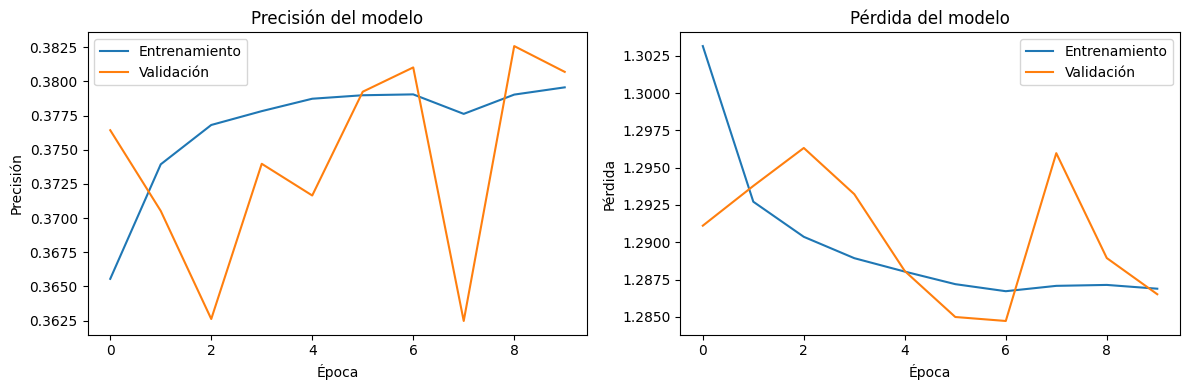

In [29]:
X, y = data_fixed.drop('RENDIMIENTO_GLOBAL', axis=1), data_fixed['RENDIMIENTO_GLOBAL']
modelo = RedNeuronal(epochs=10, batch_size=32)
modelo.ejecutar(X, y)

Analizando las gráficas de precisión y pérdida del modelo, se puede observar que no presenta problemas significativos de underfitting ni overfitting. Esto se evidencia en que las curvas de entrenamiento y validación mantienen un comportamiento similar y cercano entre sí a lo largo de las épocas, sin mostrar una brecha creciente que indicaría sobreajuste, ni un estancamiento en valores deficientes que sugeriría subajuste. La precisión de validación incluso se mantiene ligeramente superior a la de entrenamiento, mientras que la pérdida converge hacia valores similares alrededor de 1.283. Sin embargo, aunque el modelo está bien balanceado en términos de ajuste, su precisión general cercana al 38% sugiere que hay espacio para mejorar su capacidad predictiva, posiblemente mediante ajustes en la arquitectura o hiperparámetros, manteniendo este buen equilibrio entre underfitting y overfitting que ya presenta.

# Prueba con los datos de envio

In [24]:
X = pd.read_csv('test.csv')

# Llamamos a data_cleaning
X_fixed = data_cleaning(X)

if 'Unnamed: 0' in X_fixed.columns:
    X_fixed = X_fixed.drop(columns=["Unnamed: 0"])

# Mostramos el resultado
X_fixed.head()

,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,ESTU_PRIVADO_LIBERTAD,ESTU_PAGOMATRICULAPROPIO,FAMI_TIENECOMPUTADOR,FAMI_EDUCACIONMADRE,AÑO,BIMESTRE
0,0.017811,0.029580,1.0,5.0,3,1,4,1,0,0,1,1,6,2018,3
1,0.000657,0.120963,3.0,25.5,2,1,7,1,0,0,0,1,4,2020,3
2,0.003248,0.406738,2.0,0.0,3,1,5,1,0,0,0,1,7,2021,2
3,0.056812,0.012528,2.0,25.5,1,0,1,1,0,0,0,0,1,2019,5
4,0.075132,0.059625,3.0,15.5,2,1,7,1,0,0,0,1,7,2021,2


In [25]:
result=modelo.model.predict(X_fixed)

9275/9275 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


Como la red neuronal entrega una array con las probabilidades para cada clase se debe hacer el mapeo a los valores cada clase, y a adicionalmente se forma el DataFrame con loos resultados

In [26]:
class_mapping = {
    0: 'bajo',
    1: 'medio-bajo',
    2: 'medio-alto',
    3: 'alto'
}

predictions = np.argmax(result, axis=1)
predictions = [class_mapping[pred] for pred in predictions]
predictions = pd.DataFrame({'ID':X.ID,'RENDIMIENTO_GLOBAL': predictions})

In [27]:
predictions

,ID,RENDIMIENTO_GLOBAL
0,550236,bajo
1,98545,bajo
2,499179,bajo
3,782980,bajo
4,785185,bajo
...,...,...
296781,496981,bajo
296782,209415,bajo
296783,239074,bajo
296784,963852,bajo
